# MLP : CIFAR-10 

MLP는 Multi Layer Perceptron이라는 뜻을 가지고 있다.

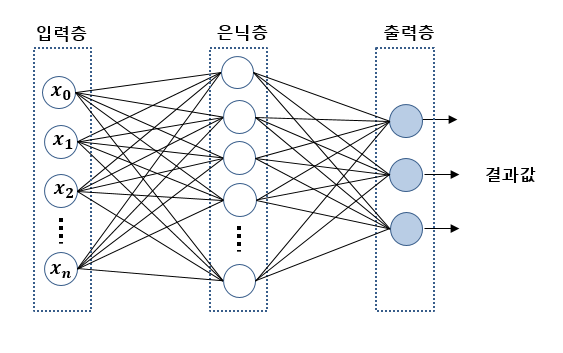

이미지를 이용하여 MLP 알고리즘을 사용할 때, input 값에 1차원 배열이 들어간다. 

이번 실험은 CIFAR-10 Dataset을 이용하여 분류를 해보겠다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
# 파이토치 인공 신경망 모델 설계
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [3]:
BATCH_SIZE =30
EPOCHS = 10

BATCH_SIZE : Mini-Batch 1개 단위에 대해 데이터가 32개로 구성돼 있는 것을 의미한다. 이를 대중적으로 1개의 Mini-Batch를 통해 학습하는 횟수를 'Iteration', 전체 데이터를 이용해 학습을 진행한 횟수를 'Epoch'라 한다.

EPOCHS: Mini-Batch 1개 단위로 Back ProPagation을 이용해 MLP의 가중값을 업데이트 하는데, Epoch는 존재하고 있는 Mini-Batch를 전부 이용하는 횟수를 의미한다. 

### 데이터 받기

In [4]:
# CIFAR10 데이터 다운
train_dataset = datasets.CIFAR10(root = '/content/data/CIFAR_10',
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = '/content/data/CIFAR_10',
                                 train = False,
                                 transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

Files already downloaded and verified


In [5]:
train_loader

컬러 이미지의 CIFAIR10 Dataset을 torchvision 내의 Datasets 함수를 이용해 데이터셋을 다운로드 한다.

ToTensor() 메서드를 이용해 Tensor 형태로 변경시킨다. 또한 한 픽셀은 0\~255 범위의 스칼라 값으로 구성돼 있는데, 이를 0~1 범위로 정규화하는 과정이 진행 된다.

#### DataLoader 란 ?

배치사이트 형태로 만들어서 우리가 실제로 학습할 때 이용할 수 있게 형태를 만들어주는 라이브러리

데이터가 생성되면, 배치형태로 만들어줘야하니까 DataLoader 라이브러리를 활용하여 형태를 만들어 준다.

      DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [6]:
# 데이터 확인하기
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([30, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([30]) type: torch.LongTensor


X_train: 32개의 이미지 데이터가 1개의 Mini_Batch를 구성하고 있고 가로 32개, 세로 32개의 픽셀로 구성돼 있으며 채널이 3이므로 Red, Green, Blue 색상으로 이뤄진, 다시 말해 컬러로 이뤄진 이미지 데이터라는 것을 확인할 수 있다.

y_train : 32개의 이미지 데이터 각각에 대해 Label 값이 1개씩 존재하기 때문에 32개의 값을 갖고 있는 것을 확인할 수 있다.

X_train 이미지 데이터는 torch.FloatTensor, y_train Label 데이터는 torch.LongTensor 형태도 확인할 수 있다.

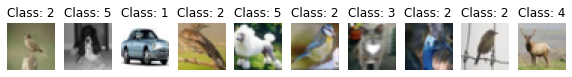

In [7]:
# 데이터 확인하기
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

[Mini-Batch, Channel, Height, Width]의 형태, 즉 1개의 Mini-Batch 내에는 32개의 데이터가 있으며 채널이 1개이며 세로 32, 가로 32인 이미지 데이터를 의미하는 [32,3,32,32]라는 데이터의 모양을 사람의 눈으로 직접 확인할 수 있도록 이미지 데이터를 시각화하기 위해[Width, Height, Channel] 형태로 변한환 후 [32, 32, 3]으로 각각 변환해 시각화합니다. 

제시된 10개의 이미지 데이터 각각은 32 \*32 * 3 개의 픽셀로 구성돼 있는 이미지이며 각 이미지별로 할당된 label 값 역시 올바르게 매칭돼 있는 것을 확인할 수 있다.

### 모델 설계

In [8]:
# Multi Layer Perceptron(MLP) 모델 설계하기
class Net(nn.Module):                       # 1
  def __init__(self):                       # 2
    super(Net, self).__init__()            # 3
    self.fc1 = nn.Linear(32 * 32 * 3, 512)  # 4
    self.fc2 = nn.Linear(512, 256)          # 5
    self.fc3 = nn.Linear(256, 10)           # 6

  def forward(self, x):                     # 7
    x = x.view(-1, 32 * 32 * 3)            # 8
    x = self.fc1(x)                         # 9
    x = F.relu(x)                           # 10
    x = self.fc2(x)                         # 11
    x = F.relu(x)                           # 12
    x = self.fc3(x)                         # 13
    x = F.log_softmax(x, dim = 1)           # 14
    return x

1. PyTorch Module 내에 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스를 정의한다. nn.Module 클래스를 상속받았을 때 nn.Module 클래스가 이용할 수 있는 함수를 그대로 이용하기 때문에 새로운 딥러닝 모델을 설계할 때 자주 이용하는 방식이다.

2. Net 클래스의 인스턴스를 생성했을 때 갖게 되는 성질을 정의하는 메서드이다.

3. nn.Module 내에 있는 메서드를 상속받아 이용한다.

4. 첫번째 Fully Connected Layer를 정의한다. CIFAR-10 이미지 데이터를 input으로 사용하기 위해 32 x 32 x 3(가로 픽셀수 x 세로 픽셀수 x 채널 수) 크기의 노드 수를 설정하고 두번째 Fully Connected Layer의 노드 수를 512개로 설정할 것이기 때문에 output의 노드 수는 512개로 설정한다. 

5. 두번째 Fully Connected Layer를 정의한다. 첫번째 Fully Connected Layer의 output 크기인 512 크기의 벡터 값을 Input으로 사용하기 위해 노드 수를 512개로 설정하고 세번째 Fully Connected Layer의 노드 수를 256으로 설정할 것이기 때문에 Output의 노드 수를 256개로 설정한다. 

6. 세번째 Fully Connected Layer를 정의한다. 두번째 Fully Connected Layer의 Output 크기인 256 크기의 벡터 값을 Input으로 사용하기 위해 노드 수를 256개, Output의 노드 수를 10개로 설정한다. CIFAR-10 Dataset는 총 10가지 클래스로 구성돼 있고 이를 표현하기 위해 Label 값은 원-핫 인코딩으로 표현되며 MLP 모델의 Output 값과 Loss를 계산하기 위해 이에 맞는 크기의 벡터를 계산해야 한다. 따라서 Output의 노드 수를 10개로 정의해야 한다.

7. Net 클래스를 이용해 설계한 MLP 모델의 Forward Propagation을 정의한다. 즉, 설계한 MLP 모델에 데이터를 입력했을 때 Output을 계산하기까지의 과정을 나열한 것을 의미한다. 

8. MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있다. 하지만 CIFAR-10 이미지 데이터는 32 x 32 x 3 크기의 2차원 데이터이다. 따라서 2차원 데이터를 1차원 데이터로 변환하기 위해 View 메서드를 이용해 32 x 32 x 3 크기의 1차원 데이터로 변환해 진행한다. 2차원의 데이터를 1차원으로 펼친다고 표현하며 Flatten 한다고 표현하기도 한다.

9. '\__init__()' method를 이용해 정의한 첫번째 Fully Connected Layer에 1차원으로 펼친 이미지 데이터를 통과시킨다.

10. Pytorch Module 중 인공 신경망 설계에 유용한 함수를 모아 놓은 'torch.nn.functional' 내에 정의된 비선형 함수인 ReLU()를 이용해 두번째 Fully Connected Layer의 Input으로 계산한다.

11. '\__init__()' method를 이용해 정의한 두번째 Fully Connected Layer에 (10)에서 ReLU() 함수를 이용해 계산된 결과값을 통과시킨다.

12. PyTorch Module 중 인공 신경망 설계에 유용한 함수를 모아 놓은 'torch.nn.functional' 내에 정의된 비선형 함수인 ReLU()를 이용해 세번째 Fully Connected Layer의 Input으로 계산한다.

13. '\__init__()' method를 이용해 정의한 세번째 Fully Connected Layer에 (11)에서 ReLu() 함수를 이용해 계산된 결과값을 통과시킨다.

14. PyTorch Module 중 인공 신경망 설계에 유용한 함수를 모아 놓은 'torch.nn.functional' 내의 'log.softmax()'를 이용해 최종 Output을 계산한다. 0부터 9까지, 총 10가지 경우의 수중 하나로 분류하는 일을 수행하기 때문에 'softmax'를 이용해 확률 값을 계산한다. 일반적인 'softmax'가 아닌 'log_softmax()'를 이용하는 이유는 Back Propagation을 이용해 학습이 좀 더 원활하게 진행될 수 있도록 하기 위해서이다.

15. 최종 계산된 x값을 Output으로 반환한다.

### 모델 확인

In [9]:
# Optimizer, Objective Function 설정하기
model = Net().to(DEVICE)                                         # 1
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)     # 2
criterion = nn.CrossEntropyLoss()                                # 3

print(model)                                                    

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


1. MLP 모델을 기존에 선정한 'DEVICE'에 할당한다. 'DEVICE' 장비를 이용해 MLP 모델을 완성하기 위한 것이다.

2. Back Propagation을 통해 파라미터를 업데이트할 때 이용하는 옵티마이저를 정의한다. 이 예제에서는 Adam 알고리즘을 이용하며, 파라미터를 업데이트할 때 반영된 학습률을 0.001로 설정한다. 보통 Adam을 기본 옵션으로 설정하며 학습률은 분석가 취향에 따라 다르게 설정하기도 한다.

3. MLP 모델이 output 값과 계산될 Label 값은 Class를 표현하는 원-핫 인코딩 값이다. MLP 모델의 output 값과 원-핫 인코딩 결과의 Loss는 CrossEntrophy를 이용해 계산하기 위해 Criterion을 'nn.CrossEntrophyLoss()'로 설정한다.

In [10]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):                    
  model.train()                                                   # 1
  for batch_idx, (image, label) in enumerate (train_loader):      # 2
    image = image.to(DEVICE)                                      # 3
    label = label.to(DEVICE)                                      # 4
    optimizer.zero_grad()                                         # 5
    output = model(image)                                         # 6
    loss = criterion(output, label)                               # 7
    loss.backward()                                               # 8
    optimizer.step()                                              # 9

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%] \tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image),
                                                                          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                          loss.item()))

MLP 모델을 설계했으므로 기존에 정의한 이미지 데이터와 레이블 데이터를 이용해 MLP 모델을 학습하는 train 함수를 정의한다.

1. 기존에 정의한 MLP 모델을 학습 상태로 지정한다.

2. 기존에 정의한 train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 Mini-Batch 단위로 묶여 저장돼 있다. 해당 train_loader 내에 Mini-Batch 단위로 저장된 데이터를 순서대로 이용해 MLP 모형을 학습시키겠다.

3. Mini-Batch 내에 있는 이미지 데이터를 이용해 MLP 모델을 학습하기 위해 기존에 정의한 장비에 할당한다.

4. Mini-Batch 내에 있는 이미지 데이터와 매칭된 레이블 데이터도 기존에 정의한 장비에 할당한다.

5. 기존에 정의한 장비에 이미지 데이터와 레이블 데이터를 할당했을 때, 과거에 이용한 Mini-Batch 내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient 값이 Optimizer에 할당돼 있으므로 Optimizer의 Gradient를 초기화한다.

6. 장비에 할당한 이미지 데이터를 MLP 모델의 Input으로 이용해 Output을 계산한다.

7. 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 Cross Entrophy를 이용해 Loss 값을 계산한다.

8. Loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient 값을 각 파라미터에 할당한다.

9. 각 파라미터별로 할당된 Gradient 값을 이용해 파라미터 값을 업데이트한다.


In [15]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()                                                         # 1
  test_loss = 0                                                        # 2
  correct = 0                                                          # 3
  with torch.no_grad():                                                # 4
    for image, label in test_loader:                                   # 5 
      image = image.to(DEVICE)                                         # 6
      label = label.to(DEVICE)                                         # 7 
      output = model(image)                                            # 8
      test_loss += criterion(output, label).item()                     # 9
      prediction = output.max(1, keepdim = True)[1]                    # 10
      correct += prediction.eq(label.view_as(prediction)).sum().item() # 11
  test_loss /= len(test_loader.dataset)                                # 12
  test_accuracy = 100. * correct / len(test_loader.dataset)            # 13    
  return test_loss, test_accuracy                                      # 14

MLP 모델 학습 과정 또는 학습이 완료된 상탱서 MLP 모델의 성능을 평가하기 위해 evaluate 함수를 정의한다.

1. 학습 과정 속 또는 학습이 완료된 MLP 모델을 학습 상태가 아닌, 평가 상태로 지정한다.

2. 기존에 정의한 test_loader 내에 있는 데이터를 이용해 Loss 값을 계산하기 위해 test_loss를 0으로 임시 설정한다.

3. 학습 과정 속 또는 학습이 완료된 MLP 모델이 올바른 Class로 분류한 경우를 세기 위해 correct = 0으로 임시 설정한다.

4. MLP 모델을 평가하는 단계에서는 Gradient를 통해 파라미터 값들이 업데이트되는 현상을 방지하기 위해 torch.no_grad() 메서드를 이용해 Gradient의 흐름을 억제한다.

5. 기존에 정의한 test_loader 내에 있는 데이터 역시 train_loader와 동일하게 Mini-Batch 단위로 저장돼 있다. Mini_Batch 내에 있는 이미지 데이터와 레이블 데이터에 반복문을 이용해 차례대로 접근한다.

6. Mini-Batch 내에 있는 이미지 데이터를 이용해 MLP 모델을 검증하기 위해 기존에 정의한 장비에 할당한다.

7. Mini-Batch 내에 있는 이미지 데이터와 매칭된 레이블 데이터도 기존에 정의한 장비에 할당한다.

8. 장비에 할당한 이미지 데이터를 MLP 모델의 Input으로 이용해 Output을 계산한다.

9. 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 Loss 값을 계산한 결과값을 test_loss에 더해 업데이트한다.

10. MLP 모델의 Output 값은 크기가 '10'인 벡터 값이다. 계산된 벡터 값 내의 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단한다.

11. MLP 모델의 최종으로 예측한 클래스 값과 실제 레이블이 의미하느 클래스를 비교해 맞으면 correct에 더해 올발르게 예측한 횟수를 저장한다.

12. 현재까지 계산된 test_loss 값을 test_loader 내에 있는 Mini-Batch 개수만큼 나눠 평균 Loss 값으로 계산한다.

13. test_loader 데이터 중 얼마나 맞췄는 지를 계산해 정확도를 계산한다.

14. 계산된 test_loss 값과 test_accuracy 값을 반환한다.

### 모델학습

In [16]:
# MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)       # 1
  test_loss, test_accuracy = evaluate(model, test_loader)         # 2
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n'.format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%] 	Train Loss: 1.785069
Train Epoch: 1 [6000/50000(12%] 	Train Loss: 1.566597
Train Epoch: 1 [12000/50000(24%] 	Train Loss: 1.533658
Train Epoch: 1 [18000/50000(36%] 	Train Loss: 1.586057
Train Epoch: 1 [24000/50000(48%] 	Train Loss: 1.656514
Train Epoch: 1 [30000/50000(60%] 	Train Loss: 1.636277
Train Epoch: 1 [36000/50000(72%] 	Train Loss: 1.309671
Train Epoch: 1 [42000/50000(84%] 	Train Loss: 1.612144
Train Epoch: 1 [48000/50000(96%] 	Train Loss: 1.826025

[EPOCH: 1], 	Test Loss: 0.0535, 	Test Accuracy: 42.04 % 

Train Epoch: 2 [0/50000(0%] 	Train Loss: 1.343229
Train Epoch: 2 [6000/50000(12%] 	Train Loss: 1.638033
Train Epoch: 2 [12000/50000(24%] 	Train Loss: 1.824956
Train Epoch: 2 [18000/50000(36%] 	Train Loss: 1.483670
Train Epoch: 2 [24000/50000(48%] 	Train Loss: 1.265932
Train Epoch: 2 [30000/50000(60%] 	Train Loss: 1.255519
Train Epoch: 2 [36000/50000(72%] 	Train Loss: 1.781988
Train Epoch: 2 [42000/50000(84%] 	Train Loss: 1.453482
Train Epoch: 2 [48

1. 정의한 train 함수를 실행합니다. model은 기존에 정의한 MLP 모델, train_loader는 학습 데이터, optimizer는 SGD, log_interval은 학습이 진행되면서 Mini_Batch의 Index를 이용해 과정을 모니터링하 수 있도록 출력하는 것을 의미한다.

2. 각 Epoch 별로 출력되는 Loss 값과 accuracy 값을 계산한다.